# Two methods for using CCCma format data 

- This notebook demonstrates two methods for practically using CCCma formatted data in python (or more generally):
   1. A compiled fortran program, `ccc2nc` to convert the raw CCCma formatted files into NetCDF.
   2. A python module to read the data directly into python data structures.

In both cases the example demonstrates use BEGO, the net atmosphere-ocean heat flux, converting/loading it into python, and plotting the data for January.

NB: In T63 data, the 129th row is an overlap row. It is normally excluded, e.g. in CMORIZED data.

Neil Swart, March 2023


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## 1. Convert a timeseries file to netcdf, using `ccc2nc`

- ccc2nc is a compiled fortran program. 
- It contains information about the T63 grid, and will insert things like lat and lon into the netcdf file, but it might not work correctly for newer CanESM5 data, for example with newer vertical levels.
- This is a legacy program, and support is limited, but it is functional and very useful.

In [2]:
%%bash
cd /scratch/n/nswart/nswart/nc_conversion                                                               # go to a scratch space
ln -s ../imsi-test-pictrl-110323/output/1000/sc_imsi-test-pictrl-110323_100001_100012_gp_bego.001  .    # link in a timeseries file
ccc2nc_linux sc_imsi-test-pictrl-110323_100001_100012_gp_bego.001                                       # convert to netcdf

ln: failed to create symbolic link ‘./sc_imsi-test-pictrl-110323_100001_100012_gp_bego.001’: File exists


 ccc2nc_driver: processing sc_imsi-test-pictrl-110323_100001_100012_gp_bego.001
 nc_write: Conversion of time coordinate to days requires delt but delt is unknown
 nc_write: No conversion will be done. 
 nc_write: To allow this conversion add delt to the command line (e.g. delt=1200)
 GRID BEGO  129   64    1        12 min,avg,max:   -676.4      0.8105       271.9     BEGO CCC2NC_0001 
 nc_write: Created file 
 sc_imsi-test-pictrl-110323_100001_100012_gp_bego.001.txt
 nc_write: Created netcdf file 
 sc_imsi-test-pictrl-110323_100001_100012_gp_bego.001.nc


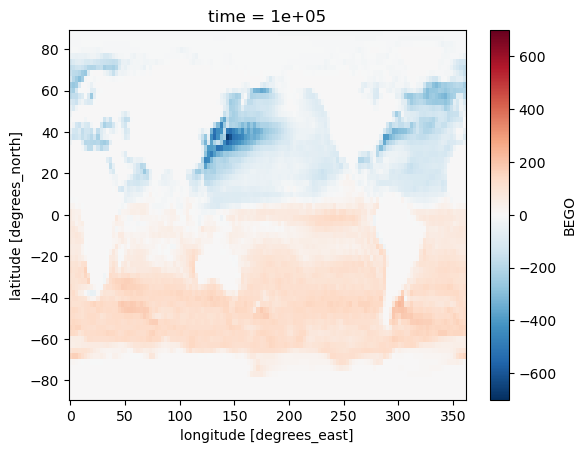

In [4]:
ds_nc = xr.open_dataset('/scratch/n/nswart/nswart/nc_conversion/sc_imsi-test-pictrl-110323_100001_100012_gp_bego.001.nc')
ds_nc.BEGO.isel(time=0).plot(vmin=-700, vmax=700, cmap='RdBu_r')

In [5]:
print(ds_nc.isel(time=0).min().values, ds_nc.isel(time=0).max().values) 

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     float64 1e+05
Data variables:
    BEGO     float64 -676.4> <bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     float64 1e+05
Data variables:
    BEGO     float64 229.1>


## 2. Use reader for reading raw CCCma format (could save as a module and load)

- This uses the `ccc.py` module, originally written by James Anstey.
- We can load data from CCCma formatted files directly into nump arrays. 
- A major issue with CCCma formated files is that they lack good metadata, most notably, lon and lat. However, these are well known for the CanAM5 / T63 grid, and can be grabbed from an existing CMIP6 nc file, or indeed computed.
- We have to reshape the 1d vectors into 2d vectors, for example.

In [6]:
import ccc # need the ccc.py module 

In [7]:
ds_ccc = ccc.read('/scratch/n/nswart/nswart/imsi-test-pictrl-110323/output/1000/sc_imsi-test-pictrl-110323_100001_100012_gp_bego.001')

32.0 2 229.0828233322278 -676.3570822677592
32.0 2 209.11353922243157 -511.9528242946611
32.0 2 160.75086889046534 -337.29557543728464
32.0 2 168.95462002909065 -326.0710733913999
32.0 2 215.67982659254724 -414.1978869707116
32.0 2 266.8494848898758 -423.48497142863005
32.0 2 271.94079613029965 -394.8992210180915
32.0 2 177.26743931249356 -279.70816133750714
32.0 2 184.35684770004272 -163.05771887974797
32.0 2 155.27250974923038 -297.43129258296017
32.0 2 220.37256950372316 -527.4184536024311
32.0 2 248.01514434178523 -523.6210650316685


In [8]:
ds_ccc[0]

{'ibuf': {'KIND': 'GRID',
  'TIME': 100001,
  'NAME': 'BEGO',
  'LEVEL': 1,
  'ILG': 129,
  'ILAT': 64,
  'KHEM': 0,
  'PACK': 2},
 'params': {'IBUF start': 64,
  'IBUF stop': 64,
  'DATA start': 33040,
  'xMin': -676.3570822677592,
  'xMax': 229.0828233322278,
  'DATA stop': 33040},
 'data': array([-4.57706847e-07, -4.57706847e-07, -4.57706847e-07, ..., -6.80919524e+00, -6.61982004e+00, -6.42452813e+00])}

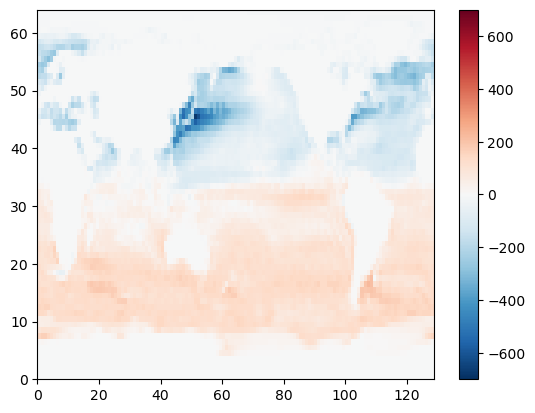

In [9]:
nlat = ds_ccc[0]['ibuf']['ILAT']
nlon = ds_ccc[0]['ibuf']['ILG']
plt.pcolormesh(ds_ccc[0]['data'].reshape(nlat,nlon), cmap='RdBu_r',vmin=-700, vmax=700)
plt.colorbar()

## Cross check by differencing the files

Note, differences at single precision are expected

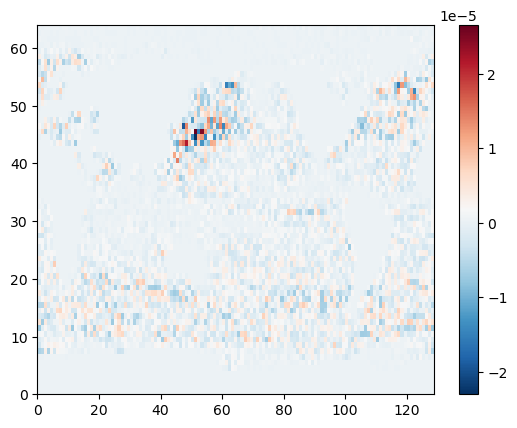

In [17]:
plt.pcolormesh(ds_nc.isel(time=0).BEGO.values - ds_ccc[0]['data'].reshape(nlat,nlon), cmap='RdBu_r')
plt.colorbar()